<a href="https://colab.research.google.com/github/Loop3D/m2l3_examples/blob/main/inclined%20parallel%20stratigraphy/Synthetic_example_parallel_and_inclined_stratigraphy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



In [1]:
# install stuff if running on Colab
if 'google.colab' in str(get_ipython()):
    !pip install git+https://github.com/Loop3D/map2model_cpp.git
    !pip install git+https://github.com/Loop3D/map2loop.git
    !pip install git+https://github.com/Loop3D/LoopStructural.git@v1.5.11
    !pip install git+https://github.com/Loop3D/LoopProjectFile.git@0.0.26
    !pip install lavavu-osmesa==1.8.60
    !pip install meshio
    !pip uninstall gdown -y
    !pip install gdown
    # data files in link below
    !gdown --folder https://drive.google.com/drive/folders/1xIOwa0dcEFsHyCtgk9x_5HyjDj6nt9ta

else:
      print('Not running on CoLab, nothing to do')

  Cloning https://github.com/Loop3D/map2model_cpp.git to /tmp/pip-req-build-5ztjjcn1
  Running command git clone --filter=blob:none --quiet https://github.com/Loop3D/map2model_cpp.git /tmp/pip-req-build-5ztjjcn1
  Resolved https://github.com/Loop3D/map2model_cpp.git to commit 4a3e59528e99a0592bd5cc213ee0eaae559b9c8a
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
  Created wheel for map2model: filename=map2model-1.2.0-cp310-cp310-linux_x86_64.whl size=4840718 sha256=60d25224b81bc93a7e4fd7adedf0bcf01450ecae86333f1a7bbd0a3c74a3fa96
  Stored in directory: /tmp/pip-ephem-wheel-cache-3f9ra88l/wheels/8e/be/f7/b722f54fd3a176ede7c9b6ddd5f939abc9e16727b997f903e9
Successfully built map2model
  Cloning https://github.com/Loop3D/map2loop.git to /tmp/pip-req-build-g6ltbglp
  Running command git clone --filter=blob:none --quiet https://github.com/Loop3D/map2loop.git /tmp/pip-req-build-g6ltbglp
  Resolved https://github.com/Loop3D/map2loop.git to 

In [3]:
import os
import time
import numpy as np
from osgeo import gdal
import pandas as pd
from datetime import datetime

from map2loop.project import Project
from map2loop.m2l_enums import VerboseLevel

from map2loop.m2l_enums import Datatype
from map2loop.sampler import SamplerSpacing, SamplerDecimator

import LoopStructural
import LoopProjectFile as LPF
from LoopStructural import GeologicalModel
from LoopStructural.visualisation import LavaVuModelViewer
from LoopStructural.modelling.input.project_file import LoopProjectfileProcessor as LPFProcessor

In [4]:
bounding_box = {
    "minx": 0,
    "miny": 0,
    "maxx": 10000,
    "maxy": 10000,
    "base": 0,
    "top": -5000,
}

nowtime=datetime.now().isoformat(timespec='minutes')
model_name=nowtime.replace(":","-").replace("T","-")
loop_project_filename = os.path.join(model_name, "local_source.loop3d")

In [6]:
proj = Project(
    geology_filename = './Laurent2016/m2l3_inputs/lithologies.shp',
    fault_filename = "./Laurent2016/m2l3_inputs/faults.shp",
    fold_filename = "./Laurent2016/m2l3_inputs/faults.shp",
    structure_filename = "./Laurent2016/m2l3_inputs/structures_v3.shp",
    dtm_filename = './Laurent2016/m2l3_inputs/DEM.tif',
    config_filename = './Laurent2016/m2l3_inputs/example.hjson',
    clut_filename = './Laurent2016/m2l3_inputs/500kibg_colours.csv',
    clut_file_legacy = True,
    verbose_level = VerboseLevel.NONE,
    tmp_path = model_name,
    working_projection = "EPSG:7854",
    bounding_box = bounding_box,
    loop_project_filename = loop_project_filename
)

Unused keys from legacy format ['msc', 'msn', 'mst', 'mtc', 'mscm', 'mcom', 'minf', 'fdipdir_flag', 'deposit_dist']
Datatype FAULT_ORIENTATION is not set and so cannot be loaded



In [7]:
# Set to only take every second orientation observation (0 or 1 means take all observations)
proj.set_sampler(Datatype.STRUCTURE, SamplerDecimator(0))
proj.set_sampler(Datatype.GEOLOGY, SamplerSpacing(100.0))

In [8]:
# Or you can run map2loop and pre-specify the stratigraphic column
column = [
    # youngest
    'Litho_K',
    'Litho_J',
    'Litho_I',
    'Litho_H',
    'Litho_G',
    'Litho_F',
    'Litho_E',
    'Litho_D',
    'Litho_C',
    'Litho_B',
    'Litho_A',
    # oldest
]

column
proj.run_all(user_defined_stratigraphic_column=column)

LPFilename = loop_project_filename
projFile = LPF.ProjectFile(LPFilename)
processedData = LPFProcessor(projFile)

Cannot calculate thickness between Litho_B and Litho_A


In [9]:
foliation_params = {
    'interpolatortype':'FDI' , # 'interpolatortype':'PLI',
    'nelements':1e5,  # how many tetras/voxels
    # 'regularisation':[5,5,10],
    'cpw': 1,
    'npw':0.5,
    'gpw':0.6,
    'solver': 'pyamg'
}

model = LoopStructural.GeologicalModel.from_processor(processedData)
model.update()

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]


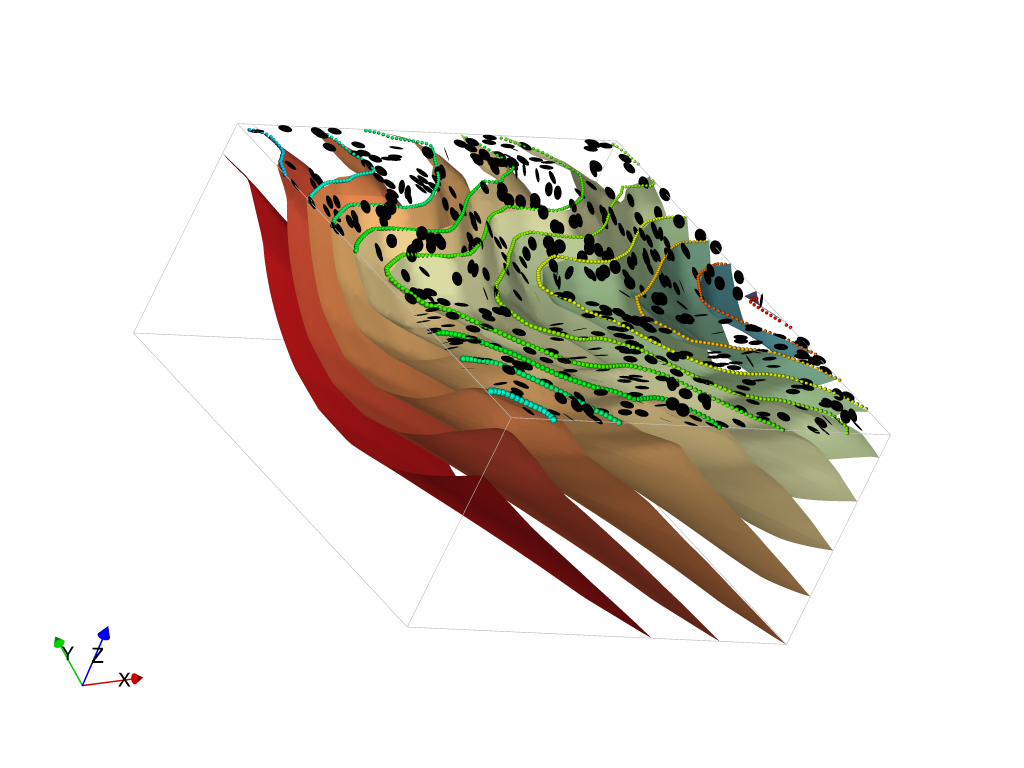

In [10]:
from google.colab import output
output.enable_custom_widget_manager()

from LoopStructural.visualisation import LavaVuModelViewer

view = LavaVuModelViewer(model)
# view.nsteps = [200, 200, 500]
view.add_data(model['sg'])
# view.add_model()
view.add_model_surfaces()

view.rotation = [-56.68132781982422, 42.125144958496094, -2.6206510066986084]
view.display()

<Axes: >

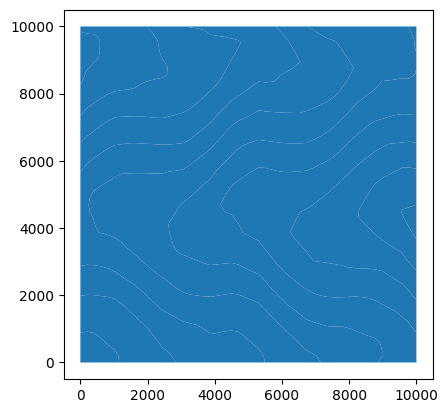

In [11]:
proj.map_data.get_map_data(Datatype.GEOLOGY).plot()

In [12]:
proj.map_data.get_map_data(Datatype.STRUCTURE)

,geometry,DIPDIR,DIP,OVERTURNED,BEDDING,ID
37,POINT (9323.566 276.265),81.0,36.6,False,True,0
179,POINT (8919.234 418.145),80.0,33.5,False,True,1
149,POINT (8638.030 423.452),82.0,33.5,False,True,2
425,POINT (9228.271 579.794),79.0,82.1,False,True,3
81,POINT (9467.220 642.335),85.0,67.3,False,True,4
...,...,...,...,...,...,...
336,POINT (6926.064 9562.854),41.7,27.9,False,True,451
139,POINT (6866.442 9644.167),20.2,45.5,False,True,452
125,POINT (5991.475 9725.806),41.6,53.6,False,True,453
335,POINT (6452.428 9747.131),26.0,46.8,False,True,454


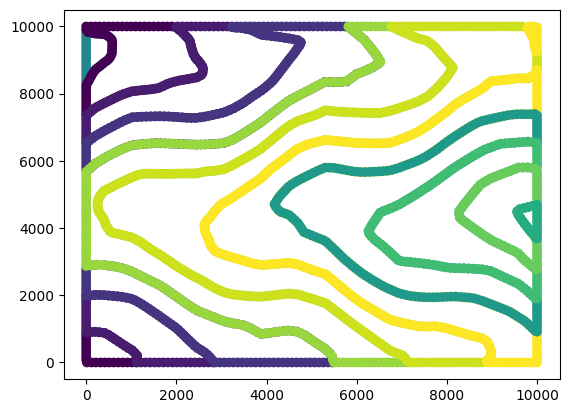

In [13]:
import matplotlib.pyplot as plt
plt.scatter(proj.geology_samples['X'], proj.geology_samples['Y'], c= proj.geology_samples['ID'])

In [14]:
proj.get_thickness_calculator()

'ThicknessCalculatorAlpha'

In [15]:
processedData.thicknesses

{'Litho_K': 602.4146812917289,
 'Litho_J': 574.2872558733877,
 'Litho_I': 656.5879056017706,
 'Litho_H': 609.979376746783,
 'Litho_G': 566.9844610139112,
 'Litho_F': 526.1135353050323,
 'Litho_E': 602.4343336237904,
 'Litho_D': 606.7571007560082,
 'Litho_C': 676.173481413148,
 'Litho_B': 602.4146812917289,
 'Litho_A': 602.4146812917289}